In [15]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    balanced_accuracy_score,
    classification_report,
    f1_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.tree import export_graphviz

In [16]:
df = pd.read_csv('../base/heart.csv')

Célula para corrigir os valores de zero

In [17]:
# Colunas com valores de zero que são clinicamente impossíveis
cols_to_correct = ["RestingBP", "Cholesterol"]

# Substituir 0 por NaN (Not a Number) para que possamos calcular a mediana corretamente
for col in cols_to_correct:
    df[col] = df[col].replace(0, np.nan)

# Calcular a mediana de cada coluna (ignorando os NaN) e preencher os valores faltantes
for col in cols_to_correct:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

Definição das Features para o Pré-processamento

In [18]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

numeric_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
nominal_categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina"]
ordinal_categorical_features = ["ST_Slope"]
st_slope_order = ["Down", "Flat", "Up"]

Criar o transformador para aplicar as operações corretas em cada tipo de coluna

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        # Aplica OneHotEncoder às colunas categóricas nominais
        (
            "nominal_encoder",
            OneHotEncoder(handle_unknown="ignore", drop="first"),
            nominal_categorical_features,
        ),  # Aplica OrdinalEncoder à coluna categórica ordinal
        (
            "ordinal_encoder",
            OrdinalEncoder(categories=[st_slope_order]),
            ordinal_categorical_features,
        ),  # Aplica um scaler às colunas numéricas
        ("numeric_scaler", RobustScaler(), numeric_features),
    ],
    remainder="passthrough",  # Mantém as colunas não especificadas (se houver alguma)
)

Criar o pipeline que une o pré-processador e o modelo

In [20]:
model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(random_state=42),
        ),  # Adicionado random_state para reprodutibilidade
    ]
)

Ajuste de hiperparâmetros

In [21]:
# Defina a distribuição de parâmetros com a sintaxe para pipelines
# Usa o nome do passo ('classifier') seguido de dois underscores ('__')
param_dist = {
    "classifier__n_estimators": randint(50, 500),
    "classifier__max_depth": randint(1, 20),
}

# Crie o objeto RandomizedSearchCV usando o pipeline
rand_search_inner = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

In [22]:
# Defina a estratégia da validação cruzada externa (LOOP EXTERNO)
# Usar StratifiedKFold é importante para manter a proporção das classes.

outer_cv = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)

f1_scores = cross_val_score(
    estimator=rand_search_inner, X=X, y=y, cv=outer_cv, scoring="f1", n_jobs=-1
)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"F1 Score Médio em 30 execuções: {mean_f1:.4f}")
print(f"Desvio Padrão do F1 Score: {std_f1:.4f}\n")

F1 Score Médio em 30 execuções: 0.8841
Desvio Padrão do F1 Score: 0.0528



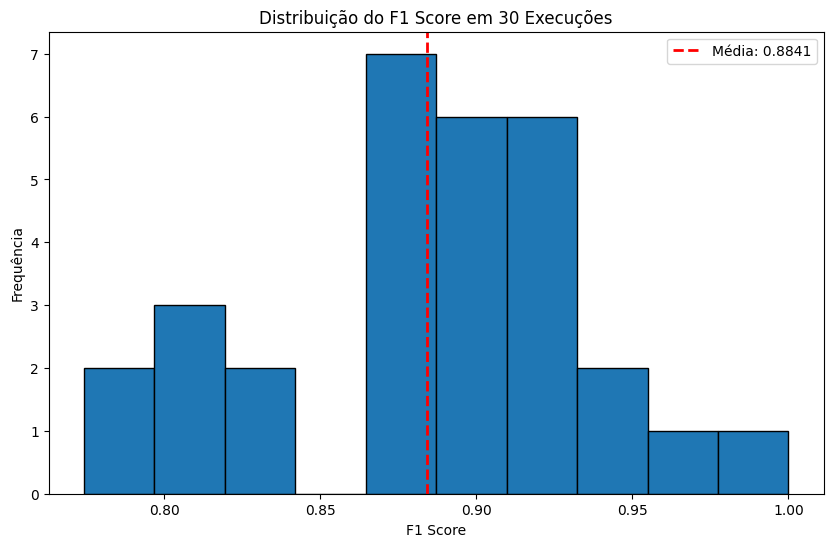

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(f1_scores, bins=10, edgecolor="black")
plt.title("Distribuição do F1 Score em 30 Execuções")
plt.xlabel("F1 Score")
plt.ylabel("Frequência")
plt.axvline(
    mean_f1, color="red", linestyle="dashed", linewidth=2, label=f"Média: {mean_f1:.4f}"
)
plt.legend()
plt.show()

Melhores parâmetros encontrados para o modelo de interpretação: 
{'classifier__max_depth': 7, 'classifier__n_estimators': 485}


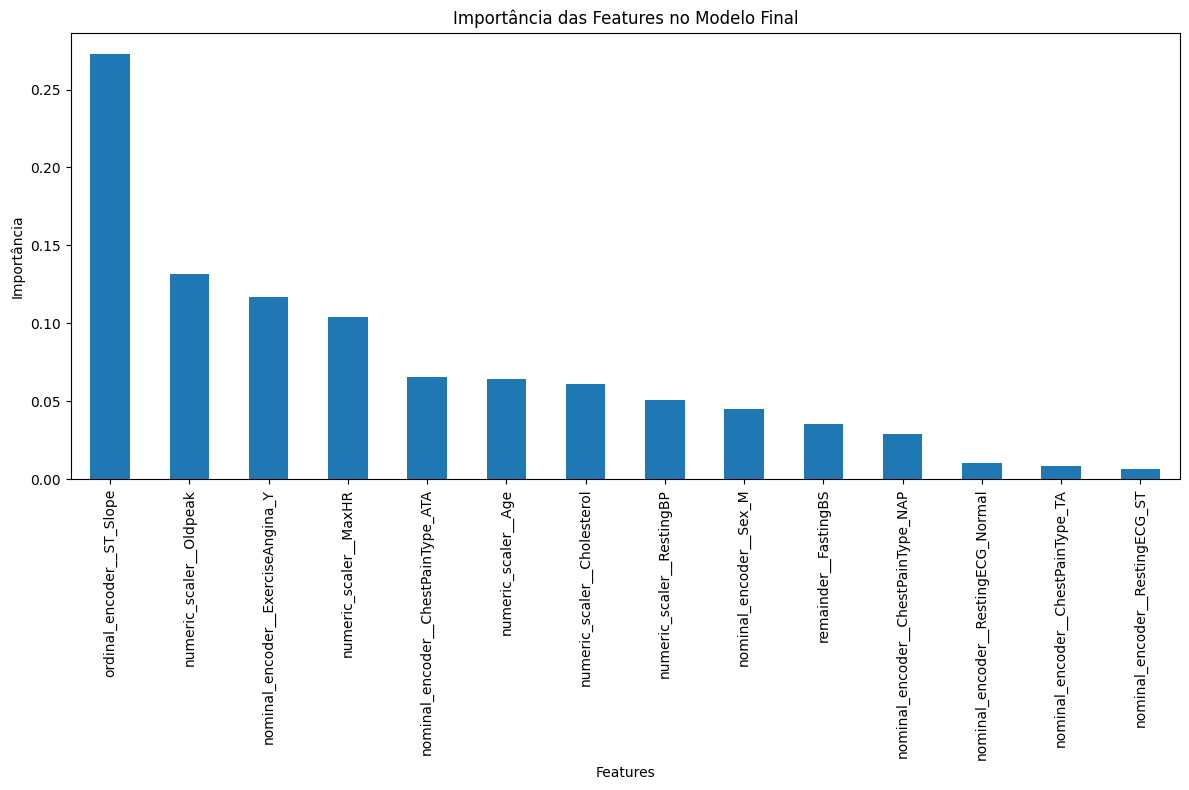

In [24]:
# Para fins de interpretabilidade, vamos treinar o RandomizedSearch uma vez no dataset completo
# para encontrar um bom conjunto de parâmetros e gerar o gráfico de importância.
rand_search_final = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
).fit(X, y)

best_model_for_interpretation = rand_search_final.best_estimator_
print(
    f"Melhores parâmetros encontrados para o modelo de interpretação: \n"
    f"{rand_search_final.best_params_}"
)

# Extração e plot da importância das features
rf_classifier = best_model_for_interpretation.named_steps["classifier"]
processed_feature_names = best_model_for_interpretation.named_steps[
    "preprocessor"
].get_feature_names_out()

feature_importances = pd.Series(
    rf_classifier.feature_importances_, index=processed_feature_names
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importances.plot.bar()
plt.title("Importância das Features no Modelo Final")
plt.ylabel("Importância")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

## Análise de Performance em uma Única Divisão de Dados (Train/Test Split)

In [25]:
# Divisão dos dados em um único conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Pegamos o melhor estimador (pipeline com os melhores parâmetros)
# encontrado na análise principal.
# Nota: best_model_for_interpretation já foi treinado no dataset completo na célula anterior.
# Para uma avaliação justa no split, o ideal é retreiná-lo apenas no X_train.
print(
    "Retreinando o melhor modelo apenas no conjunto de treino para avaliação no teste..."
)
best_model_for_interpretation.fit(X_train, y_train)

Retreinando o melhor modelo apenas no conjunto de treino para avaliação no teste...


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal_encoder', ...), ('ordinal_encoder', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
# Geração das previsões no conjunto de teste
y_pred = best_model_for_interpretation.predict(X_test)
y_pred_proba = best_model_for_interpretation.predict_proba(X_test)[:, 1]

# Cálculo e exibição do Relatório de Classificação, F1 e Acurácia Balanceada
bal_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia Balanceada: {bal_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}\n")
print(classification_report(y_test, y_pred, target_names=["Sem Doença", "Com Doença"]))

Acurácia Balanceada: 0.8936
F1 Score: 0.9062

              precision    recall  f1-score   support

  Sem Doença       0.89      0.87      0.88       103
  Com Doença       0.90      0.91      0.91       127

    accuracy                           0.90       230
   macro avg       0.90      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



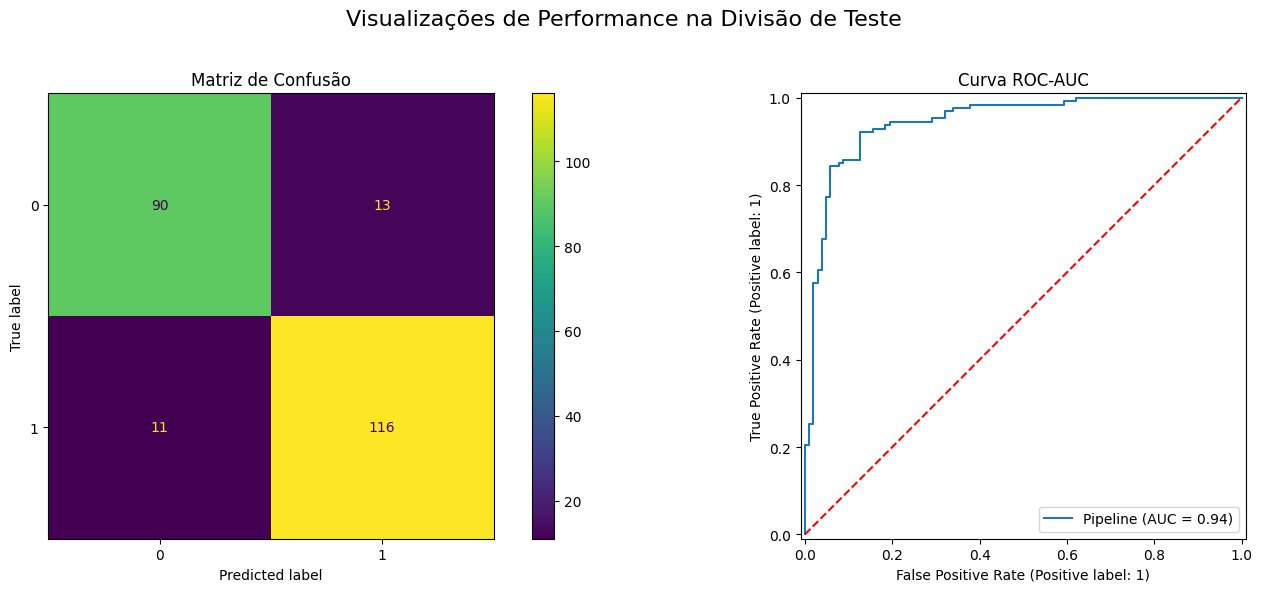

In [31]:
# Visualização da Matriz de Confusão
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Visualizações de Performance na Divisão de Teste", fontsize=16)

ConfusionMatrixDisplay.from_estimator(
    best_model_for_interpretation, X_test, y_test, ax=axes[0]
)
axes[0].set_title("Matriz de Confusão")

# 6. Visualização da Curva ROC-AUC
RocCurveDisplay.from_estimator(
    best_model_for_interpretation, X_test, y_test, ax=axes[1]
)

from sklearn.metrics import roc_curve, auc

rand_search_final = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
).fit(X, y)

y_pred_graph = rand_search_final.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

dados = {"name_model":"Random Florest", "fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": float(roc_auc)},
import json
path = '../roc_auc_data.json'
with open(path, "r", encoding="utf-8") as f:
    read_data = json.load(f)

read_data["rd_roc_auc"] = dados

with open(path, "w", encoding="utf-8") as f:
    json.dump(read_data, f, indent=4, ensure_ascii=False)

axes[1].plot([0, 1], [0, 1], "r--", label="Referência")
axes[1].set_title("Curva ROC-AUC")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()